# Monthly Electricity Consumption Forecasting for a Household.

---


Introduction:


In an era marked by escalating energy demands and the urgent need for sustainability, accurate forecasting of electricity consumption has become increasingly vital. This project focuses on developing a predictive model utilizing advanced machine learning techniques, specifically Long Short-Term Memory (LSTM) networks, to forecast household electricity consumption. By analyzing historical consumption data and associated features, the model aims to provide accurate predictions that can aid in efficient energy management and resource allocation.

The dataset employed in this study comprises comprehensive attributes, including global active power, voltage, and sub-metering data, capturing the nuances of electricity usage patterns. Through meticulous preprocessing, feature scaling, and data augmentation, the model is trained to recognize temporal dependencies in the data. The performance of the LSTM model is evaluated using various metrics, including Mean Squared Error (MSE) and R-squared, ensuring robust validation of its predictive capabilities.

This project not only contributes to the growing field of energy analytics but also supports initiatives toward more sustainable energy consumption practices, ultimately benefiting consumers and utility providers alike.

# Import Libraries


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau



*   pandas: For data manipulation.
*   numpy: For numerical operations.
*   MinMaxScaler: To normalize the data.
*   train_test_split: To split the dataset into training and testing sets.
*   mean_squared_error: To calculate the prediction error.
*   matplotlib: For data visualization.

*   tensorflow.keras: To build and train the LSTM model.









# Load the Dataset

In [ ]:
# Load the dataset from a specified file path
file_path = '/content/electricity dataset.csv'  # Specify the path to your CSV file

# Assuming the file is stored in the given path
data = pd.read_csv(file_path, sep=',', parse_dates={'DateTime': ['Date', 'Time']}, infer_datetime_format=True)

# Set DateTime as the index
data.set_index('DateTime', inplace=True)

# Display the first few rows
print(data.head())

<ipython-input-2-31dea42850c4>:5: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_path, sep=',', parse_dates={'DateTime': ['Date', 'Time']}, infer_datetime_format=True)


                    Global_active_power Global_reactive_power Voltage  \
DateTime                                                                
16-12-2006 17.24.00               4.216                 0.418  234.84   
16-12-2006 17.25.00                5.36                 0.436  233.63   
16-12-2006 17.26.00               5.374                 0.498  233.29   
16-12-2006 17.27.00               5.388                 0.502  233.74   
16-12-2006 17.28.00               3.666                 0.528  235.68   

                    Global_intensity Sub_metering_1 Sub_metering_2  \
DateTime                                                             
16-12-2006 17.24.00             18.4              0              1   
16-12-2006 17.25.00               23              0              1   
16-12-2006 17.26.00               23              0              2   
16-12-2006 17.27.00               23              0              1   
16-12-2006 17.28.00             15.8              0              1  

<ipython-input-2-31dea42850c4>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(file_path, sep=',', parse_dates={'DateTime': ['Date', 'Time']}, infer_datetime_format=True)


In [ ]:
# Check if the necessary columns are present in the dataset
print(data.columns)
print(data.info())

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 1048575 entries, 16-12-2006 17.24.00 to 13-12-2008 21.38.00
Data columns (total 7 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Global_active_power    1048575 non-null  object 
 1   Global_reactive_power  1048575 non-null  object 
 2   Voltage                1048575 non-null  object 
 3   Global_intensity       1048575 non-null  object 
 4   Sub_metering_1         1048575 non-null  object 
 5   Sub_metering_2         1048575 non-null  object 
 6   Sub_metering_3         1044506 non-null  float64
dtypes: float64(1), object(6)
memory usage: 64.0+ MB
None


# Handle Missing Values

In [ ]:
# Replace '?' with NaN and convert columns to numeric types
data.replace('?', pd.NA, inplace=True)
data = data.apply(pd.to_numeric, errors='coerce')

# Fill missing values using forward-fill
data.fillna(method='ffill', inplace=True)
data.index = pd.to_datetime(data.index, format='%d-%m-%Y %H.%M.%S')

<ipython-input-4-8a7adf6ceb6a>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


# Resample the Data to daily sums for consumption

In [ ]:
# Resample the data to daily sums for electricity consumption (Global_active_power)
if 'Global_active_power' in data.columns:
    daily_data = data.resample('D').sum()  # Changed to daily resampling
    print(daily_data.head())
else:
    print("Required column 'Global_active_power' is missing in the dataset.")
print(daily_data.info())

            Global_active_power  Global_reactive_power    Voltage  \
DateTime                                                            
2006-12-16             1209.176                 34.922   93552.53   
2006-12-17             3390.460                226.006  345725.32   
2006-12-18             2203.826                161.792  347373.64   
2006-12-19             1666.194                150.942  348479.01   
2006-12-20             2225.748                160.998  348923.61   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
DateTime                                                                      
2006-12-16            5180.8             0.0           546.0          4926.0  
2006-12-17           14398.6          2033.0          4187.0         13341.0  
2006-12-18            9247.2          1063.0          2621.0         14018.0  
2006-12-19            7094.0           839.0          7602.0          6197.0  
2006-12-20            9313.0             0

In [ ]:
# Check if all the required columns are present in daily_data before proceeding with scaling
required_columns = ['Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Global_active_power']
missing_columns = [col for col in required_columns if col not in daily_data.columns]

if not missing_columns:
    # Scale the input features and target separately
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))

    X_data = daily_data[['Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]  # Example features
    y_data = daily_data[['Global_active_power']]  # Target

    scaled_X = scaler_X.fit_transform(X_data)
    scaled_y = scaler_y.fit_transform(y_data)

    # Data Augmentation: Generate synthetic data using random noise
    noise_X = np.random.normal(0, 0.05, size=scaled_X.shape)  # Gaussian noise for features
    noise_y = np.random.normal(0, 0.1, size=scaled_y.shape)  # Gaussian noise for target

    augmented_X = scaled_X + noise_X  # Augment features with noise
    augmented_y = scaled_y + noise_y  # Augment target with noise

    # Clip augmented data to ensure they remain within the [0, 1] range
    augmented_X = np.clip(augmented_X, 0, 1)
    augmented_y = np.clip(augmented_y, 0, 1)

    # Combine original and augmented data
    combined_X = np.vstack((scaled_X, augmented_X))  # Combine features
    combined_y = np.vstack((scaled_y, augmented_y))  # Combine targets
    print(f"Shape of combined_X: {combined_X.shape}")
    print(f"Shape of combined_y: {combined_y.shape}")


else:
    print(f"Missing required columns: {missing_columns}")

Shape of combined_X: (1458, 6)
Shape of combined_y: (1458, 1)


 Checks if required columns are present in a DataFrame (`daily_data`). If all columns are available, it:

1. **Scales Data**: Uses `MinMaxScaler` to scale input features and target values to a range of [0, 1].
2. **Augments Data**: Generates random Gaussian noise and adds it to the scaled data to create synthetic variations.
3. **Clips Values**: Ensures that augmented data remains within the [0, 1] range.
4. **Combines Data**: Merges original and augmented data, printing their shapes.

This prepares the dataset for training, enhancing its size and diversity.



# Create Sequences for LSTM

In [ ]:

    timesteps = 30  # Example sequence length for LSTM
    num_features = combined_X.shape[1]

    # Reshaping
    X_reshaped = np.array([combined_X[i:i + timesteps] for i in range(len(combined_X) - timesteps)])
    y_reshaped = combined_y[timesteps:]

    print("Shape of X:", X_reshaped.shape)  # Output the new shape for verification
    print("Shape of y:", y_reshaped.shape)


Shape of X: (1428, 30, 6)
Shape of y: (1428, 1)


Reshapes the combined dataset for input into an LSTM model:

Timesteps: Sets a sequence length of 30 for the LSTM input.

Reshaping: Creates sequences of features (X_reshaped) by taking slices of combined_X, each of length equal to timesteps. The target values (y_reshaped) are taken from combined_y, offset by the length of the timesteps to align with the input sequences.

Output Shapes: Prints the shapes of X_reshaped and y_reshaped to verify the reshaping process.

This prepares the data for time-series forecasting using LSTM, ensuring that each input sequence corresponds to the appropriate target value.



# Split the Dataset into Train and Test Sets

Split the data into training (80%) and testing (20%) subsets.

In [ ]:
# Train-validation split
X_train_scaled, X_val_scaled, y_train_scaled, y_val_scaled = train_test_split(
    X_reshaped, y_reshaped, test_size=0.2, random_state=42
)

# Print details about the splits
print("Training and validation sets created.")
print(f"Shape of X_train_scaled: {X_train_scaled.shape}")
print(f"Shape of X_val_scaled: {X_val_scaled.shape}")
print(f"Shape of y_train_scaled: {y_train_scaled.shape}")
print(f"Shape of y_val_scaled: {y_val_scaled.shape}")



Training and validation sets created.
Shape of X_train_scaled: (1142, 30, 6)
Shape of X_val_scaled: (286, 30, 6)
Shape of y_train_scaled: (1142, 1)
Shape of y_val_scaled: (286, 1)


#  Build the LSTM Model

In [ ]:

# Define the LSTM model
model = Sequential()

# Add an LSTM layer with 64 units (can be adjusted) and input shape matching the sequenced data
model.add(LSTM(units=64, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))

# Output layer for regression (predicting a single value)
model.add(Dense(1))

# Compile the model
# Set a lower learning rate if needed (e.g., 0.001)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# Print model summary to verify the architecture
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          18,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,241 (71.25 KB)

 Trainable params: 18,241 (71.25 KB)

 Non-trainable params: 0 (0.00 B)



*   
The Adam optimizer is used because it adapts the learning rate for each parameter, allowing for faster convergence and robustness to noisy data. Its efficiency and minimal need for tuning make it suitable for large datasets.
*   Mean Squared Error (MSE) is chosen as the loss function because it is sensitive to outliers, provides smooth gradients for easier optimization, and offers a clear interpretation of model performance by measuring the average squared difference between predicted and actual values. This combination makes it effective for regression tasks like predicting monthly energy consumption.



Epoch 1/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0417 - val_loss: 0.0206
Epoch 2/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0189 - val_loss: 0.0184
Epoch 3/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0189 - val_loss: 0.0175
Epoch 4/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0164 - val_loss: 0.0179
Epoch 5/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0144 - val_loss: 0.0164
Epoch 6/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0158 - val_loss: 0.0162
Epoch 7/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0158 - val_loss: 0.0173
Epoch 8/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0161 - val_loss: 0.0165
Epoch 9/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0156 - val_loss: 0.0160
Epoch 10/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0163 - val_loss: 0.0159
Epoch 11/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0151 - val_loss: 0.0160
Epoch 12/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 

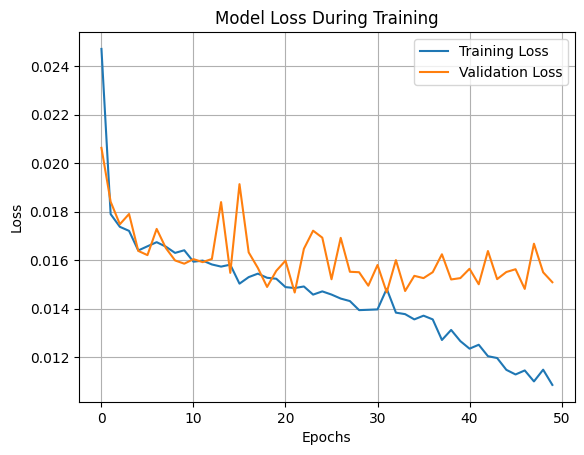

In [ ]:
# Train the model
history = model.fit(X_train_scaled, y_train_scaled, validation_data=(X_val_scaled, y_val_scaled), epochs=50, batch_size=5)

# Plot the training and validation loss

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Evaluate the Model

In [ ]:

y_train_target = y_train_scaled[:, -1]  # Select the last column for y_train
y_val_target = y_val_scaled[:, -1]      # Select the last column for y_val

# Ensure predictions are in the correct shape
y_train_pred = model.predict(X_train_scaled)  # Get predictions for the training set
y_train_pred = y_train_pred.flatten()          # Flatten predictions to 1D if needed

y_val_pred = model.predict(X_val_scaled)      # Get predictions for the validation set
y_val_pred = y_val_pred.flatten()              # Flatten predictions to 1D if needed

# Calculate metrics for the training set
train_mse = mean_squared_error(y_train_target, y_train_pred)
train_mae = mean_absolute_error(y_train_target, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train_target, y_train_pred)

# Calculate metrics for the validation set
val_mse = mean_squared_error(y_val_target, y_val_pred)
val_mae = mean_absolute_error(y_val_target, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_val_target, y_val_pred)

# Print metrics for both training and validation sets
print(f'Training Set Metrics:')
print(f'  MSE: {train_mse:.4f}')
print(f'  MAE: {train_mae:.4f}')
print(f'  RMSE: {train_rmse:.4f}')
print(f'  R-squared: {train_r2:.4f}')

print(f'\nValidation Set Metrics:')
print(f'  MSE: {val_mse:.4f}')
print(f'  MAE: {val_mae:.4f}')
print(f'  RMSE: {val_rmse:.4f}')
print(f'  R-squared: {val_r2:.4f}')


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Training Set Metrics:
  MSE: 0.0101
  MAE: 0.0774
  RMSE: 0.1007
  R-squared: 0.6042

Validation Set Metrics:
  MSE: 0.0151
  MAE: 0.0923
  RMSE: 0.1229
  R-squared: 0.3798


Evaluates the performance of a trained machine learning model on both the training and validation datasets:

1. **Target Selection**: It selects the last column of the scaled training (`y_train_scaled`) and validation (`y_val_scaled`) datasets as the target variables (`y_train_target` and `y_val_target`).

2. **Predictions**: The model generates predictions for both the training (`y_train_pred`) and validation sets (`y_val_pred`). The predictions are flattened to ensure they are in 1D format.

3. **Metric Calculation**:
   - **MSE** (Mean Squared Error), **MAE** (Mean Absolute Error), **RMSE** (Root Mean Squared Error), and **R-squared** are calculated for both training and validation sets to assess model performance.
   
4. **Results Output**: It prints the calculated metrics for both sets, providing insight into how well the model performs during training and on unseen validation data.

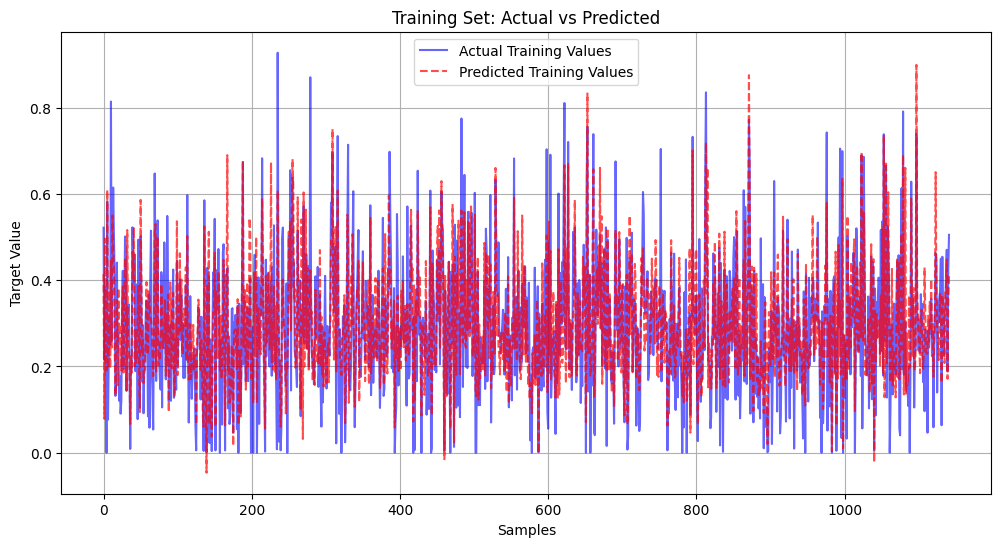

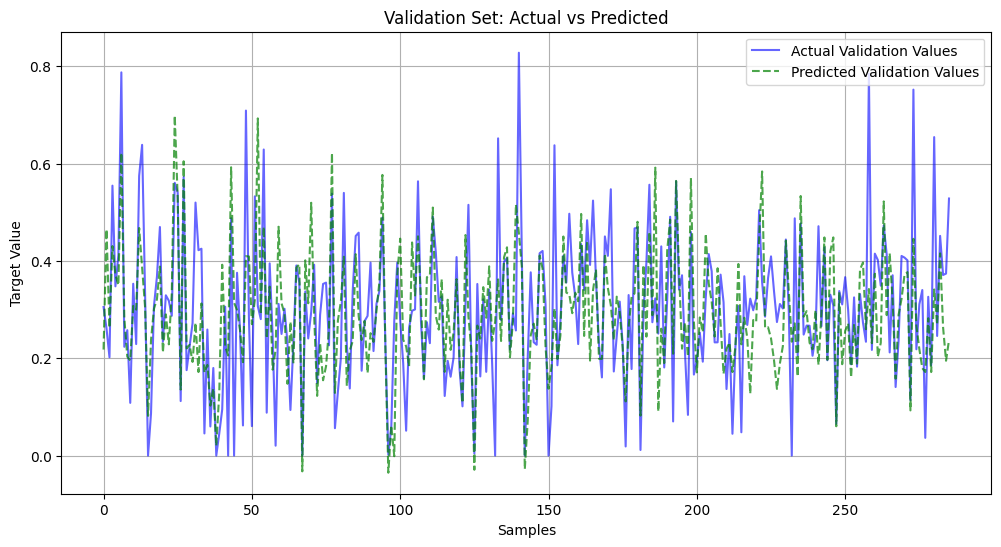

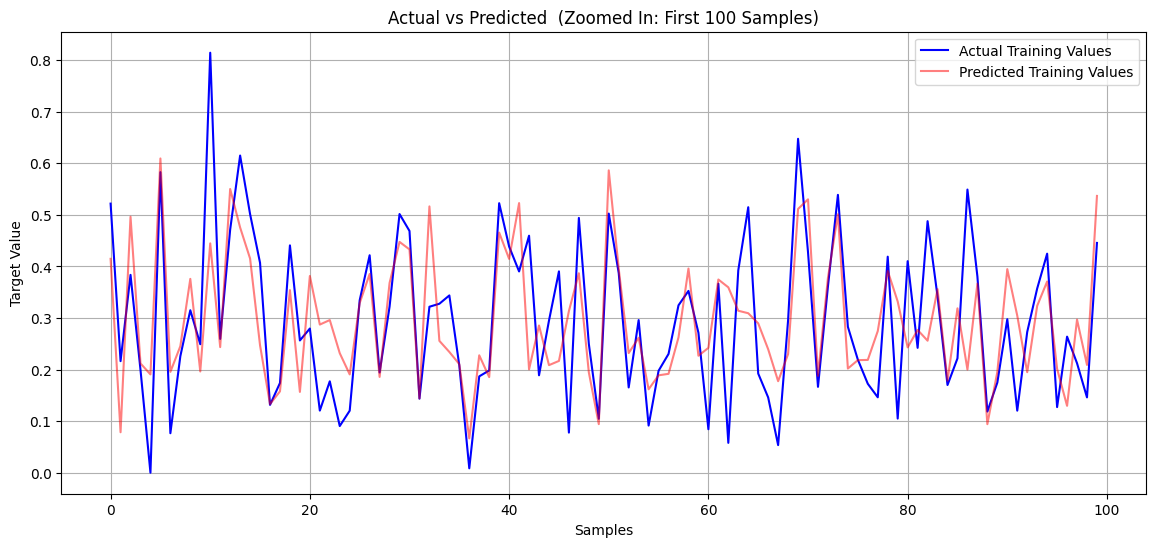

In [ ]:

# Ensure predictions and actual values are flattened for plotting
y_train_pred = y_train_pred.flatten()
y_val_pred = y_val_pred.flatten()
y_train_target = y_train_target.flatten()
y_val_target = y_val_target.flatten()

# Plot for Training Set
plt.figure(figsize=(12, 6))
plt.plot(y_train_target, label='Actual Training Values', color='blue', alpha=0.6)
plt.plot(y_train_pred, label='Predicted Training Values', color='red', linestyle='--', alpha=0.7)
plt.title('Training Set: Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot for Validation Set
plt.figure(figsize=(12, 6))
plt.plot(y_val_target, label='Actual Validation Values', color='blue', alpha=0.6)
plt.plot(y_val_pred, label='Predicted Validation Values', color='green', linestyle='--', alpha=0.7)
plt.title('Validation Set: Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(y_train_target[:100], label='Actual Training Values', color='blue')
plt.plot(y_train_pred[:100], label='Predicted Training Values', color='red', alpha=0.5)  # Add transparency
plt.title('Actual vs Predicted  (Zoomed In: First 100 Samples)')
plt.xlabel('Samples')
plt.ylabel('Target Value')
plt.legend()
plt.grid()
plt.show()
